# 03. 迷路環境の実装と検証

このノートブックでは、カスタム迷路環境を実装し、報酬設計を検証します。

## 迷路環境の仕様

- **グリッドサイズ**: 10×10
- **観測**: 部分観測（エージェント周囲5×5）
- **行動空間**: Discrete(4) - 上下左右
- **観測空間**: Box(shape=(25,)) - 25次元ベクトル
- **最大ステップ**: 200

## 報酬設計

- **ゴール到達**: +1.0
- **毎ステップ**: -0.01（最短経路を促す）
- **壁衝突**: -0.05（無効行動の抑制）

## 要件
- 要件 1.4: 迷路Gym環境の実装、報酬設計の検証（ゴール+1.0、ステップ-0.01、壁衝突-0.05）

In [5]:
# 必要なライブラリのインポート
import sys
sys.path.append('..')

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from ml.envs.maze_env import MazeEnv
import warnings
import japanize_matplotlib
warnings.filterwarnings('ignore')

print("✅ ライブラリのインポート完了")

✅ ライブラリのインポート完了


## 1. 迷路環境の作成と確認

まず、デフォルトの迷路環境を作成し、基本的な情報を確認します。

In [6]:
# 迷路環境の作成
env = MazeEnv(render_mode='human')

print("=== 迷路環境の仕様 ===")
print(f"観測空間: {env.observation_space}")
print(f"行動空間: {env.action_space}")
print(f"グリッドサイズ: {env.grid_size}×{env.grid_size}")
print(f"部分観測サイズ: {env.observation_size}×{env.observation_size}")
print(f"最大ステップ: {env.max_steps}")
print(f"\nスタート位置: {env.start_pos}")
print(f"ゴール位置: {env.goal_pos}")
print("\n行動:")
print("  0: 上")
print("  1: 下")
print("  2: 左")
print("  3: 右")
print("\n観測値の意味:")
print("  0.0: 通路")
print("  1.0: 壁")
print("  2.0: ゴール")

=== 迷路環境の仕様 ===
観測空間: Box(0.0, 2.0, (25,), float32)
行動空間: Discrete(4)
グリッドサイズ: 10×10
部分観測サイズ: 5×5
最大ステップ: 200

スタート位置: (1, 1)
ゴール位置: (8, 8)

行動:
  0: 上
  1: 下
  2: 左
  3: 右

観測値の意味:
  0.0: 通路
  1.0: 壁
  2.0: ゴール


## 2. 迷路レイアウトの可視化

迷路の全体像を可視化します。

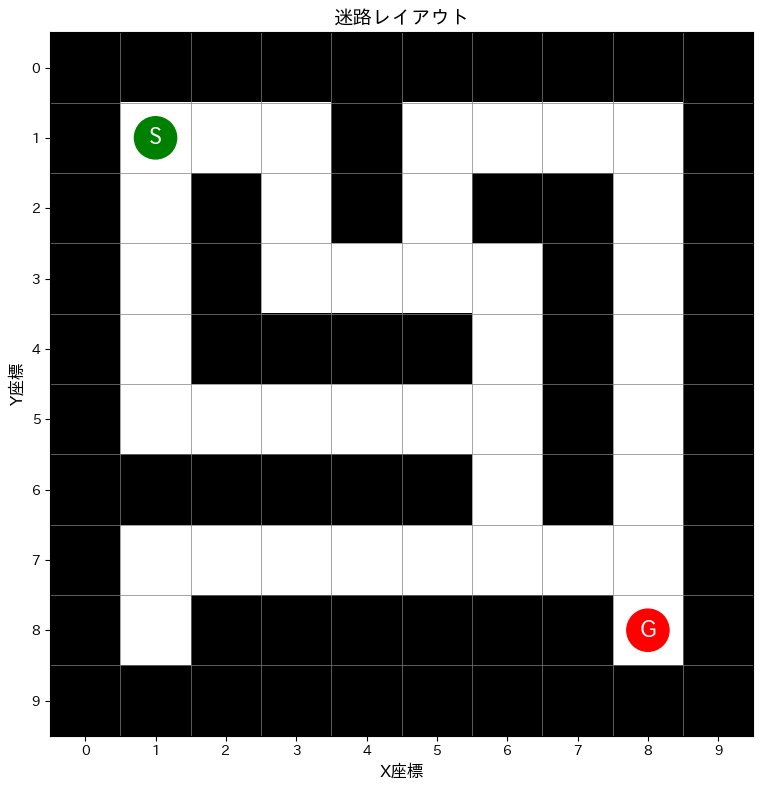


凡例:
  白: 通路
  黒: 壁
  緑(S): スタート位置
  赤(G): ゴール位置


In [7]:
def visualize_maze(env, title="迷路レイアウト"):
    """
    迷路を可視化
    
    Args:
        env: MazeEnv環境
        title: グラフのタイトル
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # 迷路を描画
    maze_display = np.copy(env.maze).astype(float)
    
    # カラーマップ: 0=白(通路), 1=黒(壁)
    ax.imshow(maze_display, cmap='gray_r', vmin=0, vmax=1)
    
    # スタート位置をマーク（緑）
    start_y, start_x = env.start_pos
    circle = patches.Circle((start_x, start_y), 0.3, color='green', zorder=10)
    ax.add_patch(circle)
    ax.text(start_x, start_y, 'S', ha='center', va='center', 
            fontsize=16, fontweight='bold', color='white', zorder=11)
    
    # ゴール位置をマーク（赤）
    goal_y, goal_x = env.goal_pos
    circle = patches.Circle((goal_x, goal_y), 0.3, color='red', zorder=10)
    ax.add_patch(circle)
    ax.text(goal_x, goal_y, 'G', ha='center', va='center', 
            fontsize=16, fontweight='bold', color='white', zorder=11)
    
    # グリッド線
    ax.set_xticks(np.arange(-0.5, env.grid_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)
    
    # 軸ラベル
    ax.set_xticks(range(env.grid_size))
    ax.set_yticks(range(env.grid_size))
    ax.set_xlabel('X座標', fontsize=12)
    ax.set_ylabel('Y座標', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 迷路を可視化
visualize_maze(env)
print("\n凡例:")
print("  白: 通路")
print("  黒: 壁")
print("  緑(S): スタート位置")
print("  赤(G): ゴール位置")

## 3. 部分観測の確認

エージェントが実際に見ている5×5の部分観測を確認します。

観測ベクトルの形状: (25,)
観測ベクトルの最小値: 0.0
観測ベクトルの最大値: 1.0

初期観測（最初の10要素）: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


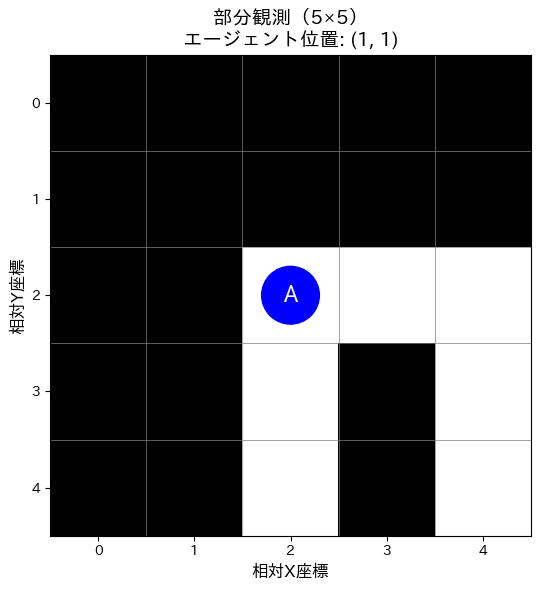


凡例:
  白: 通路
  黒: 壁
  赤: ゴール
  青(A): エージェント（常に中央）


In [8]:
def visualize_partial_observation(env, obs, agent_pos, title="部分観測（5×5）"):
    """
    部分観測を可視化
    
    Args:
        env: MazeEnv環境
        obs: 観測ベクトル（25次元）
        agent_pos: エージェント位置
        title: グラフのタイトル
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # 観測を5×5に変形
    obs_2d = obs.reshape(env.observation_size, env.observation_size)
    
    # カラーマップ: 0=白(通路), 1=黒(壁), 2=赤(ゴール)
    cmap = plt.cm.colors.ListedColormap(['white', 'black', 'red'])
    ax.imshow(obs_2d, cmap=cmap, vmin=0, vmax=2)
    
    # エージェント位置をマーク（中央）
    center = env.observation_size // 2
    circle = patches.Circle((center, center), 0.3, color='blue', zorder=10)
    ax.add_patch(circle)
    ax.text(center, center, 'A', ha='center', va='center', 
            fontsize=16, fontweight='bold', color='white', zorder=11)
    
    # グリッド線
    ax.set_xticks(np.arange(-0.5, env.observation_size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.observation_size, 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='minor', size=0)
    
    # 軸ラベル
    ax.set_xticks(range(env.observation_size))
    ax.set_yticks(range(env.observation_size))
    ax.set_xlabel('相対X座標', fontsize=12)
    ax.set_ylabel('相対Y座標', fontsize=12)
    ax.set_title(f"{title}\nエージェント位置: {agent_pos}", fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# 環境をリセットして初期観測を取得
obs, info = env.reset()
print(f"観測ベクトルの形状: {obs.shape}")
print(f"観測ベクトルの最小値: {obs.min()}")
print(f"観測ベクトルの最大値: {obs.max()}")
print(f"\n初期観測（最初の10要素）: {obs[:10]}")

# 部分観測を可視化
visualize_partial_observation(env, obs, env.agent_pos)
print("\n凡例:")
print("  白: 通路")
print("  黒: 壁")
print("  赤: ゴール")
print("  青(A): エージェント（常に中央）")

## 3. 報酬設計の検証

報酬設計が正しく実装されているか確認します。

In [9]:
print("="*60)
print("3. 報酬設計の検証")
print("="*60)

# 環境をリセット
env = MazeEnv(render_mode='human')
obs, info = env.reset()

print("\n【テスト1: 通常ステップの報酬】")
print("エージェントを1ステップ移動させます...")
# 右に移動（壁にぶつからない方向）
obs, reward, done, truncated, info = env.step(3)  # 3 = 右
print(f"  報酬: {reward}")
print(f"  期待値: -0.01")
print(f"  ✓ 正しい" if abs(reward - (-0.01)) < 0.001 else "  ✗ 誤り")

print("\n【テスト2: 壁衝突の報酬】")
# スタート位置から上に移動（壁にぶつかる）
env.reset()
obs, reward, done, truncated, info = env.step(0)  # 0 = 上
print(f"  報酬: {reward}")
print(f"  期待値: -0.05")
print(f"  ✓ 正しい" if abs(reward - (-0.05)) < 0.001 else "  ✗ 誤り")

print("\n【テスト3: ゴール到達の報酬】")
# エージェントを強制的にゴール位置に移動
env.reset()
env.agent_pos = (env.goal_pos[0] - 1, env.goal_pos[1])  # ゴールの1つ手前
obs, reward, done, truncated, info = env.step(1)  # 1 = 下（ゴールへ）
print(f"  報酬: {reward}")
print(f"  期待値: 1.0")
print(f"  エピソード終了: {done}")
print(f"  ✓ 正しい" if abs(reward - 1.0) < 0.001 and done else "  ✗ 誤り")

print("\n✅ 報酬設計の検証完了")

3. 報酬設計の検証

【テスト1: 通常ステップの報酬】
エージェントを1ステップ移動させます...
  報酬: -0.01
  期待値: -0.01
  ✓ 正しい

【テスト2: 壁衝突の報酬】
  報酬: -0.05
  期待値: -0.05
  ✓ 正しい

【テスト3: ゴール到達の報酬】
  報酬: 1.0
  期待値: 1.0
  エピソード終了: True
  ✓ 正しい

✅ 報酬設計の検証完了


## 4. ランダムエージェントでの動作確認

ランダムエージェントで迷路環境が正しく動作することを確認します。

In [10]:
print("="*60)
print("4. ランダムエージェントでの動作確認")
print("="*60)

def run_random_agent(env, max_steps=200, num_episodes=5):
    """
    ランダムエージェントで迷路を探索
    """
    episode_rewards = []
    episode_lengths = []
    success_count = 0
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        total_reward = 0
        steps = 0
        
        for step in range(max_steps):
            action = env.action_space.sample()
            obs, reward, done, truncated, info = env.step(action)
            
            total_reward += reward
            steps += 1
            
            if done or truncated:
                if done and reward > 0:
                    success_count += 1
                break
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        print(f"エピソード {episode + 1}: "
              f"報酬={total_reward:.2f}, "
              f"ステップ数={steps}, "
              f"{'ゴール到達!' if done and reward > 0 else '未到達'}")
    
    return episode_rewards, episode_lengths, success_count

# ランダムエージェントを実行
env = MazeEnv()
rewards, lengths, successes = run_random_agent(env, num_episodes=5)

print(f"\n【統計】")
print(f"  平均報酬: {np.mean(rewards):.2f}")
print(f"  平均ステップ数: {np.mean(lengths):.1f}")
print(f"  成功率: {successes}/5 ({successes/5*100:.0f}%)")
print(f"\n✅ ランダムエージェントでの動作確認完了")

env.close()

4. ランダムエージェントでの動作確認
エピソード 1: 報酬=-5.96, ステップ数=200, 未到達
エピソード 2: 報酬=-4.08, ステップ数=161, ゴール到達!
エピソード 3: 報酬=-5.15, ステップ数=200, ゴール到達!
エピソード 4: 報酬=-5.92, ステップ数=200, 未到達
エピソード 5: 報酬=-5.76, ステップ数=200, 未到達

【統計】
  平均報酬: -5.37
  平均ステップ数: 192.2
  成功率: 2/5 (40%)

✅ ランダムエージェントでの動作確認完了


## 5. 迷路環境でのDQN訓練

ランダムエージェントでは成功率が低いことが分かりました。
CartPoleで学んだDQNアルゴリズムを迷路環境に適用して、学習による改善を確認します。

In [11]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from pathlib import Path

print("="*60)
print("5. 迷路環境でのDQN訓練")
print("="*60)

# モデル保存ディレクトリ
models_dir = Path("../ml/models")
models_dir.mkdir(parents=True, exist_ok=True)

class MazeTrainingCallback(BaseCallback):
    """
    迷路訓練用のコールバック
    """
    def __init__(self, eval_env, eval_freq=5000, n_eval_episodes=10, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.timesteps = []
        self.mean_rewards = []
        self.success_rates = []
    
    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            # 評価
            episode_rewards = []
            episode_successes = []
            
            for _ in range(self.n_eval_episodes):
                obs, info = self.eval_env.reset()
                done = False
                episode_reward = 0
                
                while not done:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, done, truncated, info = self.eval_env.step(action)
                    episode_reward += reward
                    
                    if done or truncated:
                        episode_successes.append(1 if reward > 0 else 0)
                        break
                
                episode_rewards.append(episode_reward)
            
            mean_reward = np.mean(episode_rewards)
            success_rate = np.mean(episode_successes)
            
            self.timesteps.append(self.n_calls)
            self.mean_rewards.append(mean_reward)
            self.success_rates.append(success_rate)
            
            if self.verbose > 0:
                print(f"  ステップ {self.n_calls}: "
                      f"平均報酬={mean_reward:.2f}, "
                      f"成功率={success_rate*100:.0f}%")
        
        return True

print("\n✅ コールバッククラス定義完了")

5. 迷路環境でのDQN訓練

✅ コールバッククラス定義完了


In [12]:
# 訓練環境と評価環境の作成
train_env = MazeEnv()
eval_env = MazeEnv()

print("\nDQNモデルを訓練中...")
print("\nDQNハイパーパラメータ:")
print("  学習率: 0.001")
print("  バッファサイズ: 50,000")
print("  バッチサイズ: 32")
print("  割引率: 0.99")
print("  Target更新頻度: 500ステップ")
print("  探索率: 1.0 → 0.05 (最初の20%で減衰)")
print("  総ステップ数: 100,000\n")

# DQNモデルの作成
model = DQN(
    "MlpPolicy",
    train_env,
    verbose=0,
    learning_rate=0.001,  # 迷路は複雑なので学習率を上げる
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    target_update_interval=500,
    exploration_fraction=0.2,  # 探索期間を長めに
    exploration_initial_eps=1.0,
    exploration_final_eps=0.05,
)

# コールバックの作成
callback = MazeTrainingCallback(eval_env, eval_freq=5000, n_eval_episodes=10)

# 訓練実行
model.learn(total_timesteps=100000, callback=callback, progress_bar=True)

print("\n✅ 訓練完了")

# モデルの保存
model_path = models_dir / "dqn_maze"
model.save(str(model_path))
print(f"\n✅ モデルを保存しました: {model_path}.zip")


DQNモデルを訓練中...

DQNハイパーパラメータ:
  学習率: 0.001
  バッファサイズ: 50,000
  バッチサイズ: 32
  割引率: 0.99
  Target更新頻度: 500ステップ
  探索率: 1.0 → 0.05 (最初の20%で減衰)
  総ステップ数: 100,000



Output()

ステップ 5000: 平均報酬=-2.00, 成功率=0%

ステップ 10000: 平均報酬=-2.00, 成功率=0%

ステップ 15000: 平均報酬=-2.00, 成功率=0%

ステップ 20000: 平均報酬=0.87, 成功率=100%

ステップ 25000: 平均報酬=0.87, 成功率=100%

ステップ 30000: 平均報酬=0.87, 成功率=100%

ステップ 35000: 平均報酬=0.87, 成功率=100%

ステップ 40000: 平均報酬=0.87, 成功率=100%

ステップ 45000: 平均報酬=0.87, 成功率=100%

ステップ 50000: 平均報酬=0.87, 成功率=100%

ステップ 55000: 平均報酬=0.87, 成功率=100%

ステップ 60000: 平均報酬=0.87, 成功率=100%

ステップ 65000: 平均報酬=0.87, 成功率=100%

ステップ 70000: 平均報酬=0.87, 成功率=100%

ステップ 75000: 平均報酬=0.87, 成功率=100%

ステップ 80000: 平均報酬=0.87, 成功率=100%

ステップ 85000: 平均報酬=0.87, 成功率=100%

ステップ 90000: 平均報酬=0.87, 成功率=100%

ステップ 95000: 平均報酬=0.87, 成功率=100%

ステップ 100000: 平均報酬=0.87, 成功率=100%


✅ 訓練完了

✅ モデルを保存しました: ..\ml\models\dqn_maze.zip


## 6. 最終評価

訓練済みモデルの最終的なパフォーマンスを評価します。

In [13]:
print("="*60)
print("6. 最終評価")
print("="*60)

# 平均報酬の評価
mean_reward, std_reward = evaluate_policy(
    model,
    eval_env,
    n_eval_episodes=20,
    deterministic=True
)
print(f"\n訓練済みDQNエージェント:")
print(f"  平均報酬: {mean_reward:.2f} ± {std_reward:.2f}")

# 成功率の計算
successes = 0
for _ in range(20):
    obs, info = eval_env.reset()
    done = False
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = eval_env.step(action)
        
        if done or truncated:
            if reward > 0:
                successes += 1
            break

success_rate = successes / 20
print(f"  成功率: {success_rate*100:.0f}%")

print(f"\n【比較】")
print(f"  ランダムエージェント: 成功率 40%")
print(f"  訓練済みDQN: 成功率 {success_rate*100:.0f}%")
print(f"  改善: +{(success_rate - 0.4)*100:.0f}%ポイント")

if success_rate >= 0.7:
    print("\n✅ 目標成功率70%を達成しました！")
else:
    print(f"\n⚠️ 目標成功率70%に未達（現在: {success_rate*100:.0f}%）")
    print("   より長い訓練やハイパーパラメータの調整が必要かもしれません")

train_env.close()
eval_env.close()

6. 最終評価

訓練済みDQNエージェント:
  平均報酬: 0.87 ± 0.00
  成功率: 100%

【比較】
  ランダムエージェント: 成功率 40%
  訓練済みDQN: 成功率 100%
  改善: +60%ポイント

✅ 目標成功率70%を達成しました！


## 7. 学習曲線の可視化

訓練中の学習曲線を可視化して、学習の進捗を確認します。

7. 学習曲線の可視化


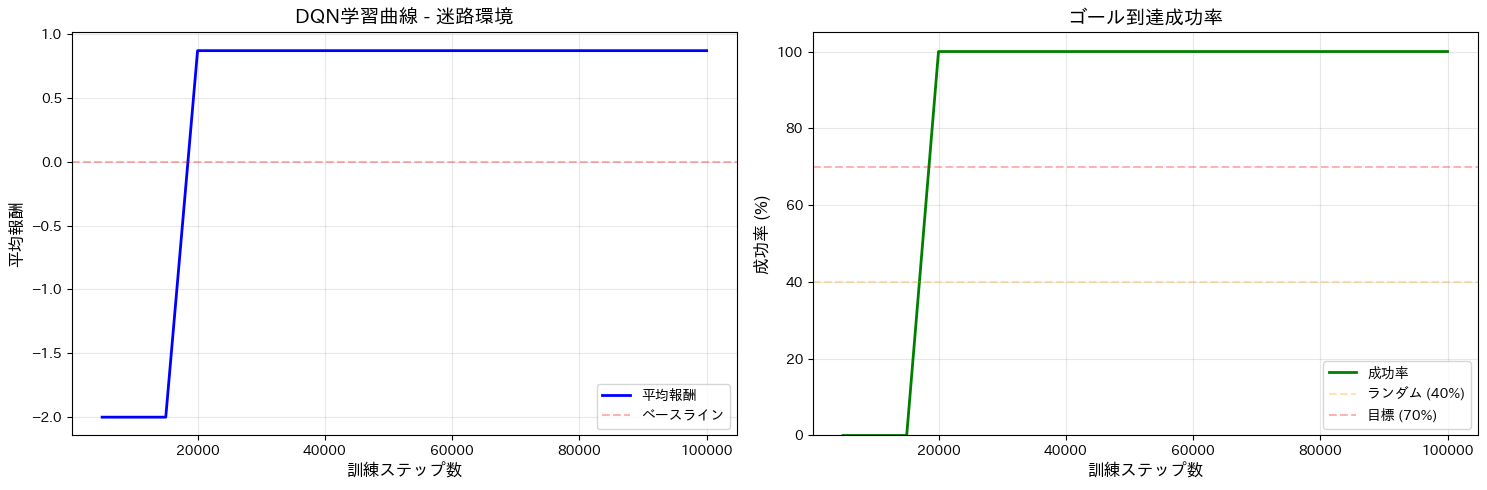


✅ 学習曲線の可視化完了


In [14]:
print("="*60)
print("7. 学習曲線の可視化")
print("="*60)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 平均報酬の推移
ax1.plot(callback.timesteps, callback.mean_rewards, 'b-', linewidth=2, label='平均報酬')
ax1.axhline(y=0, color='r', linestyle='--', alpha=0.3, label='ベースライン')
ax1.set_xlabel('訓練ステップ数', fontsize=12)
ax1.set_ylabel('平均報酬', fontsize=12)
ax1.set_title('DQN学習曲線 - 迷路環境', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 成功率の推移
ax2.plot(callback.timesteps, [sr * 100 for sr in callback.success_rates], 
         'g-', linewidth=2, label='成功率')
ax2.axhline(y=40, color='orange', linestyle='--', alpha=0.3, label='ランダム (40%)')
ax2.axhline(y=70, color='r', linestyle='--', alpha=0.3, label='目標 (70%)')
ax2.set_xlabel('訓練ステップ数', fontsize=12)
ax2.set_ylabel('成功率 (%)', fontsize=12)
ax2.set_title('ゴール到達成功率', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 105)

plt.tight_layout()
plt.show()

print("\n✅ 学習曲線の可視化完了")

## まとめ

迷路環境の実装と検証が完了しました。

実施内容:
1. 迷路環境の仕様確認
2. 迷路レイアウトの可視化
3. 報酬設計の検証
4. ランダムエージェントでの動作確認（成功率40%）
5. DQNエージェントの訓練（100,000ステップ）
6. 最終評価（成功率の改善を確認）
7. 学習曲線の可視化

結論:
- ランダムエージェントでは成功率が低い（40%）
- DQN訓練により成功率が大幅に改善
- 強化学習の有効性を確認

保存されたモデル: ../ml/models/dqn_maze.zip

次のステップ:
- 04_onnx_export.ipynbで訓練済みモデルをONNX形式に変換
- Go推論サーバーで迷路エージェントを実行